# Portfolio Project: Data Analysis on Tennis stats

## TABLE OF CONTENTS
1. Introduction
2. Imports and Functions
3. The Data
4. Data Preparation
5. Data Processing
6. Data Analysis and Visualization
7. Conclusions
8. Improvements & Next Steps
9. References

## 1. INTRODUCTION
For those who don't know, I spent more than one year working on a predictive system able to make money consistently and profitably by betting on NBA games. I started this journey on September 2019 and, as of December 2020, I had found an approach that way better than what I had hoped to find.

That's when Netty was born and, an entire regular season after, I can proudly say that it yielded a 9.14% ROI betting mostly on underdogs (average odds were 2.15) and made more than 51 units in profits just in 280 games. To put an example, someone with a unit of 100€ would have finished with **over 5100€ in less than 5 months**. 

Being the ambitious person that I am, I wasn't going to settle with something that was profitable only during 6 months. I want to earn money consistently and regularly, that's why I need another model able to work the entire year.

There were different options: tennis, horse racing, greyhound racing... I ended up choosing tennis because I'm not particularly a fan of animal racing and tennis is a much more famous sport (and that usually means more data).

Now, I won't be creating the model and doing all the work that comes after. This project will consist in all the previous phases: from data manipulation to data analysis, to data visualization, to getting data almost ready for modelling time. So **expect the analysis to move towards the direction of finding those relevant features** to use in a predictive model. 

I'll then, privately, use the insights I'll discover to create the model and hopefully make it profitable enough.

## 2. IMPORTS AND FUNCTIONS

This might not be the most efficient practice but I like to keep things organized and I can't think of a better way to do so.

Below, you'll be able to see the packages I'm using throughout the entire document and also some external functions that will help me make this path easier.

In [1]:
#######################################################################################
# IMPORTS
#######################################################################################

# Math
import numpy as np
import math, statistics

# Data manipulation
import pandas as pd
from fuzzywuzzy import fuzz, process

# Data visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Extras
from tqdm import tqdm
import time

# Shutting down warnings, just to make things cleaner
import warnings
warnings. simplefilter(action='ignore', category=Warning)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

In [2]:
#######################################################################################
# FUNCTIONS
#######################################################################################

def divider(ini, stop, denominator):
    '''Acts as a range() but instead of adding up or subtracting, it multiplies/divides'''
    l = []
    if ini > stop:
        while ini > stop:
            l.append(int(ini))
            ini /= denominator
    else:
        while ini < stop:
            l.append(int(ini))
            ini *= denominator
        
    return l

def compute_diff(df, cols):
    '''This computes the difference of certain features between player1 and player2'''
    # ALWAYS player 1 - player 2
    # cols shouldn't have player suffixes
    for col in cols:
        df[col + "_diff"] = df['p1_' + col] - df['p2_' + col]
    return df

def myround(x, base=.5):
    '''This rounds to the desired base (default to .5)'''
    return base * round(x/base)

def f(x):
    '''This will be used to display information when grouping by odds or confidence'''
    d = {}
    d["Games"] = x["Right"].count()
    d['Accuracy'] = x['Right'].mean()
    d['Mean Odds'] = x['Odd'].mean()
    d['Profits (unit)'] = x['Profits_unit'].sum()
    d['Profits (odd)'] = x['Profits_odd'].sum()
    d['ROI (unit)'] = x['Profits_unit'].sum() / x['Odd'].count()
    d['ROI (odd)'] = x['Profits_odd'].sum() / x['Odd'].sum()
    return pd.Series(d, index=d.keys())

## 3. THE DATA
The available data consists in two different types of files, both types extracted from different sources, and as many files per type as years between 2005 and 2021 (both included). 

* **data/atp_matches_{year}.csv**: they contain valuable qualitative information (like each player's hand, surface, tourney level...) as well as quantitative data from that particular event (typical match stats).
* **data/{year}.xls[x]**: these mainly contain information related to odds as well as the match results and metadata. 

Let's quickly see a sneak peek of both types:

In [3]:
pd.read_csv("data/atp_matches_2021.csv").head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2021-0499,Delray Beach,Hard,32,A,20210104,300,128034,4.0,NaN,Hubert Hurkacz,R,NaN,POL,23.895962,200624,NaN,NaN,Sebastian Korda,R,NaN,USA,20.501027,6-3 6-3,3,F,71.0,4.0,0.0,50.0,38.0,27.0,7.0,9.0,0.0,1.0,1.0,5.0,55.0,33.0,20.0,9.0,9.0,1.0,5.0,35,1518,119.0,566.0
1,2021-0499,Delray Beach,Hard,32,A,20210104,299,128034,4.0,NaN,Hubert Hurkacz,R,NaN,POL,23.895962,106328,NaN,Q,Christian Harrison,R,NaN,USA,26.603696,7-6(4) 6-4,3,SF,97.0,7.0,1.0,70.0,44.0,30.0,15.0,11.0,2.0,3.0,5.0,4.0,70.0,46.0,29.0,13.0,11.0,3.0,5.0,35,1518,789.0,22.0
2,2021-0499,Delray Beach,Hard,32,A,20210104,298,200624,NaN,NaN,Sebastian Korda,R,NaN,USA,20.501027,111815,NaN,NaN,Cameron Norrie,L,NaN,GBR,25.368925,6-3 7-5,3,SF,81.0,6.0,4.0,60.0,36.0,29.0,11.0,11.0,0.0,2.0,3.0,5.0,56.0,35.0,25.0,7.0,10.0,2.0,6.0,119,566,74.0,877.0
3,2021-0499,Delray Beach,Hard,32,A,20210104,297,106328,NaN,Q,Christian Harrison,R,NaN,USA,26.603696,126149,NaN,NaN,Gianluca Mager,R,NaN,ITA,26.094456,7-6(2) 6-4,3,QF,94.0,2.0,4.0,69.0,47.0,39.0,12.0,11.0,3.0,4.0,5.0,6.0,83.0,45.0,34.0,18.0,11.0,9.0,11.0,789,22,101.0,733.0
4,2021-0499,Delray Beach,Hard,32,A,20210104,296,128034,4.0,NaN,Hubert Hurkacz,R,NaN,POL,23.895962,105933,NaN,Q,Roberto Quiroz,L,NaN,ECU,28.865161,6-4 6-4,3,QF,85.0,2.0,1.0,54.0,39.0,29.0,8.0,10.0,2.0,3.0,2.0,1.0,68.0,43.0,28.0,10.0,10.0,7.0,10.0,35,1518,293.0,171.0


In [4]:
pd.read_excel("data/2021.xlsx").head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,WPts,LPts,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Basilashvili N.,Arnaboldi A.,40,267.0,1395,206.0,4.0,6.0,7.0,5.0,6.0,1.0,NaN,NaN,NaN,NaN,2.0,1.0,Completed,1.50,2.50,1.61,2.44,1.67,2.56,1.56,2.42
1,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Celikbilek A.,Zuk K.,309,262.0,150,209.0,7.0,6.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,2.50,1.50,2.63,1.54,2.70,1.55,2.57,1.50
2,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Ruusuvuori E.,Vesely J.,87,67.0,806,928.0,6.0,3.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.50,2.50,1.56,2.58,1.63,3.03,1.52,2.53
3,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Bublik A.,Caruso S.,49,76.0,1090,858.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.61,2.20,1.81,2.09,1.87,2.30,1.72,2.11
4,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Goffin D.,Herbert P.H.,16,83.0,2555,822.0,3.0,6.0,7.0,5.0,6.0,0.0,NaN,NaN,NaN,NaN,2.0,1.0,Completed,1.40,2.75,1.46,2.92,1.50,3.00,1.44,2.78


## 4. DATA PREPARATION

This will be a pretty mechanical process which will consist in a series of steps:

1. Create the necessary transformations to join datasets (that is, normalize player and tournament names, dates...)
2. Join datasets, create one per year.
3. Get rid of unnecessary columns.
4. Reorganize dataset: from winner and loser to player1 and player2, evenly distributed (that means, half the time player1 won and the other half was won by player2). Also create a new column names "Player1Win".
5. Create new features?


### 4.1. Transform identifier columns
The plan is to join both types of dataframes and, to do so, I'll be using the following columns as identifiers (format: column_name_df1 = column_name_df2), some of which I'll have to create:
* Month = month
* Year = year
* winner = winner_name
* loser = loser_name

If we look closer to both types of dataframes, one has full names for both player names while the other has just the last name followed by the initial letter of the player's name. I'll be using the fuzzywuzzy package to perform some string matching.

In [5]:
years = [y for y in range(2005, 2022)]
d = {}

for year in tqdm(years):
    # Type of XLS file changed in 2013. We'll read them accordingly.
    if year < 2013:
        df1 = pd.read_excel("data/{}.xls".format(year))
    else:
        df1 = pd.read_excel("data/{}.xlsx".format(year))
    df2 = pd.read_csv("data/atp_matches_{}.csv".format(year))
    
    # Converting dates into two columns: year and month -> year will always be the same as the iteration variable 
    # but let's do things right just in case
    df1["Year"] = df1["Date"].dt.year
    df1["Month"] = df1["Date"].dt.month
    df2["year"] = df2["tourney_date"].astype(str).str[:4].astype(int)
    df2["month"] = df2["tourney_date"].astype(str).str[4:6].astype(int)
    
    # Formatting strings in player names to match the other df
    l = []
    w = []
    players_w = pd.unique(df2["winner_name"])
    players_l = pd.unique(df2["loser_name"])
    for i,row in df1.iterrows():
        winner = row["Winner"]
        loser = row["Loser"]
        
        w1 = process.extract(winner, players_w)
        l1 = process.extract(loser, players_l)
        
        if len(w1) > 0:
            w.append(w1[0][0])
        else:
            w.append("")
            
        if len(l1) > 0:
            l.append(l1[0][0])
        else:
            l.append("")
            
    df1["winner"] = w
    df1["loser"] = l
    
    d[year] = [df1, df2]

100%|██████████| 17/17 [26:25<00:00, 93.27s/it]


### 4.2. Join datasets

In [6]:
for year in years:
    d[year] = d[year][0].merge(d[year][1], left_on=["Month", "Year", "winner", "loser"], right_on=["month", "year", "winner_name", "loser_name"])

As expected, we've lost some matches in the process and it's an average 13.24%. Is that a lot? Is it not? I'd say it's higher than the ideal but still good enough. 

### 4.3. Remove unwanted columns

First of all, not all dataframes have the same columns, so we must add consistency here. Let's quickly go over all of them to see which has the lowest number of columns.

In [7]:
for year in d:
    print("{} has {} columns".format(year, len(d[year].columns)))

2005 has 93 columns
2006 has 93 columns
2007 has 93 columns
2008 has 93 columns
2009 has 93 columns
2010 has 97 columns
2011 has 97 columns
2012 has 97 columns
2013 has 97 columns
2014 has 97 columns
2015 has 95 columns
2016 has 95 columns
2017 has 95 columns
2018 has 95 columns
2019 has 91 columns
2020 has 91 columns
2021 has 91 columns


2021 is the one with the fewest columns. Let's use them as a basis and see if the other years have the same ones.

Then, of all the columns available right now, I'll be removing some which I think won't have any relevance. I'll be keeping some of these though for better understanding of the data.

I'll make sure all available games have been completed (not finished by injury or other causes), also to keep those rows in which ATP ranks and ATP points coincide in both dfs and to remove those rows without odds.

Lastly, I'll be creating one single dataframe from them all, so we have all the data in one single data structure.

In [8]:
cols = d[2021].columns.tolist() # Choosing 2021 because it's the one with less columns

for year in d:
    cols = [col for col in cols if col in d[year].columns]
print("Final number of columns: {}".format(len(cols)))

# Unwanted columns
remove = ["ATP", "Location", "Tournament", "Date", "Series", "Best of", "Winner", "Loser", "Year", "Month", 
          "tourney_id", "tourney_name", "surface", "draw_size", "tourney_level", "tourney_date", "match_num",
          "winner_id", "winner_entry", "winner_seed", "winner", "loser", "winner_ioc", "loser_id", "loser_seed",
          "loser_entry", "loser_ioc", "score", "best_of", "round", "winner_rank", "loser_rank", "winner_rank_points",
          "loser_rank_points", "Comment"
         ]
wanted_cols = [col for col in cols if col not in remove]

# Making sure ranks and points coincide, also checking that the game had been completed and odds are not missing.
for year in d:
    d[year] = d[year][(d[year]["WRank"] == d[year]["winner_rank"]) & (d[year]["LRank"] == d[year]["loser_rank"]) & 
            (d[year]["WPts"] == d[year]["winner_rank_points"]) & (d[year]["LPts"] == d[year]["loser_rank_points"])
            & (d[year]["Comment"] == "Completed") & (~d[year]["B365W"].isna()) & (~d[year]["B365L"].isna())
           ][wanted_cols]

# Creating a single dataframe for all data, using just the desired columns
df = pd.concat([d[year] for year in d])
df.reset_index(drop=True, inplace=True)
df = df[['Court', 'Surface', 'Round', 'year', 'month', 'minutes', 
         'winner_name', 'WRank', 'WPts', 'W1', 'W2', 'W3', 'W4', 'W5', 'Wsets', 'B365W', 'winner_hand', 'winner_ht',
         'winner_age', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 
         'w_bpFaced',
         'loser_name', 'LRank', 'LPts', 'L1', 'L2', 'L3', 'L4', 'L5', 'Lsets', 'B365L', 'loser_hand', 'loser_ht', 
         'loser_age', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 
         'l_bpFaced']]

# I'll keep working with the same variable, df, all the time (aesthetics). It's a good practice to save 
# the current work in another variable, just in case I mess up later.
df_v1 = df.copy()

df.head()

Final number of columns: 85


,Court,Surface,Round,year,month,minutes,winner_name,WRank,WPts,W1,W2,W3,W4,W5,Wsets,B365W,winner_hand,winner_ht,winner_age,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,loser_name,LRank,LPts,L1,L2,L3,L4,L5,Lsets,B365L,loser_hand,loser_ht,loser_age,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,Outdoor,Clay,1st Round,2005,7,69.0,Tommy Robredo,20.0,1425.0,7.0,6,NaN,NaN,NaN,2.0,1.10,R,180.0,23.175907,2.0,1.0,51.0,34.0,25.0,11.0,9.0,1.0,2.0,Michal Tabara,112.0,381.0,5.0,0,NaN,NaN,NaN,0.0,6.00,R,175.0,25.897331,0.0,11.0,67.0,27.0,14.0,19.0,9.0,3.0,8.0
1,Outdoor,Clay,1st Round,2005,7,50.0,Mikhail Youzhny,27.0,1200.0,6.0,6,NaN,NaN,NaN,2.0,1.19,R,183.0,23.025325,0.0,1.0,35.0,20.0,15.0,13.0,7.0,0.0,0.0,Jerome Haehnel,109.0,391.0,1.0,1,NaN,NaN,NaN,0.0,4.00,R,185.0,24.971937,1.0,1.0,52.0,28.0,13.0,8.0,7.0,4.0,9.0
2,Outdoor,Clay,1st Round,2005,7,61.0,Juan Carlos Ferrero,31.0,1150.0,6.0,6,NaN,NaN,NaN,2.0,1.07,R,183.0,25.390828,0.0,0.0,51.0,36.0,22.0,9.0,8.0,2.0,4.0,Lukas Dlouhy,136.0,315.0,4.0,1,NaN,NaN,NaN,0.0,7.00,R,185.0,22.236824,1.0,6.0,51.0,24.0,14.0,8.0,9.0,4.0,10.0
3,Outdoor,Clay,1st Round,2005,7,67.0,Tomas Berdych,42.0,811.0,6.0,6,NaN,NaN,NaN,2.0,1.19,R,196.0,19.794661,6.0,1.0,57.0,33.0,28.0,14.0,9.0,2.0,2.0,Kevin Kim,71.0,541.0,2.0,3,NaN,NaN,NaN,0.0,4.00,R,180.0,26.940452,7.0,2.0,53.0,31.0,20.0,9.0,8.0,5.0,8.0
4,Outdoor,Clay,1st Round,2005,7,66.0,Nicolas Almagro,88.0,469.0,6.0,6,NaN,NaN,NaN,2.0,2.75,R,183.0,19.868583,3.0,0.0,55.0,39.0,26.0,10.0,9.0,5.0,7.0,Jose Acasuso,44.0,781.0,4.0,1,NaN,NaN,NaN,0.0,1.39,R,190.0,22.704997,0.0,2.0,49.0,20.0,12.0,10.0,8.0,3.0,8.0


### 4.4. Reorganize dataset
I think it's a good time to start shaping the data as we will need it. Instead of having winner and loser, I'll create player1 and player2. For future purposes, I'll make that half the time will win player1, the other half will be for player2 (keeping it as it is now, the output would learn that the first player always wins and that would be a huge mistake).

Obviously, I'll need an extra column telling which player won: "p1_win".

In [9]:
data = []
p1_wins = []

inverted_cols = df.columns[:6].tolist() + df.columns[28:].tolist() + df.columns[6:28].tolist()

final_cols = ['Court', 'Surface', 'Round', 'year', 'month', 'minutes', 
              'p1_name', 'p1_Rank', 'p1_Pts', 'p1_1', 'p1_2', 'p1_3', 'p1_4', 'p1_5', 'p1_sets', 'p1_B365', 
              'p1_hand', 'p1_ht', 'p1_age', 'p1_ace', 'p1_df', 'p1_svpt', 'p1_1stIn', 'p1_1stWon', 'p1_2ndWon', 
              'p1_SvGms', 'p1_bpSaved', 'p1_bpFaced',
              'p2_name', 'p2_Rank', 'p2_Pts', 'p2_1', 'p2_2', 'p2_3', 'p2_4', 'p2_5', 'p2_sets', 'p2_B365', 
              'p2_hand', 'p2_ht', 'p2_age', 'p2_ace', 'p2_df', 'p2_svpt', 'p2_1stIn', 'p2_1stWon', 'p2_2ndWon', 
              'p2_SvGms', 'p2_bpSaved', 'p2_bpFaced']

for i,row in tqdm(df.iterrows()):
    if len(p1_wins) == 0 or statistics.mean(p1_wins) <= 0.5: # More 0 than 1 (or same) -> we add 1 (that means, player1 is the one who won)
        p1_wins.append(1)
        data.append(row.tolist())
    else:
        p1_wins.append(0)
        data.append(row[inverted_cols].tolist())
        
df = pd.DataFrame(data, columns = final_cols)
df["p1_2"] = df["p1_2"].astype(float)
df["p1_3"] = df["p1_3"].replace(" ", np.nan)
df["p1_3"] = df["p1_3"].astype(float)
df["p2_2"] = df["p2_2"].astype(float)
df["p2_3"] = df["p2_3"].replace(" ", np.nan)
df["p2_3"] = df["p2_3"].astype(float)
df["p1_win"] = p1_wins
df

32307it [05:22, 100.25it/s]


,Court,Surface,Round,year,month,minutes,p1_name,p1_Rank,p1_Pts,p1_1,p1_2,p1_3,p1_4,p1_5,p1_sets,p1_B365,p1_hand,p1_ht,p1_age,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,p1_SvGms,p1_bpSaved,p1_bpFaced,p2_name,p2_Rank,p2_Pts,p2_1,p2_2,p2_3,p2_4,p2_5,p2_sets,p2_B365,p2_hand,p2_ht,p2_age,p2_ace,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_win
0,Outdoor,Clay,1st Round,2005,7,69.0,Tommy Robredo,20.0,1425.0,7.0,6.0,NaN,NaN,NaN,2.0,1.10,R,180.0,23.175907,2.0,1.0,51.0,34.0,25.0,11.0,9.0,1.0,2.0,Michal Tabara,112.0,381.0,5.0,0.0,NaN,NaN,NaN,0.0,6.00,R,175.0,25.897331,0.0,11.0,67.0,27.0,14.0,19.0,9.0,3.0,8.0,1
1,Outdoor,Clay,1st Round,2005,7,50.0,Jerome Haehnel,109.0,391.0,1.0,1.0,NaN,NaN,NaN,0.0,4.00,R,185.0,24.971937,1.0,1.0,52.0,28.0,13.0,8.0,7.0,4.0,9.0,Mikhail Youzhny,27.0,1200.0,6.0,6.0,NaN,NaN,NaN,2.0,1.19,R,183.0,23.025325,0.0,1.0,35.0,20.0,15.0,13.0,7.0,0.0,0.0,0
2,Outdoor,Clay,1st Round,2005,7,61.0,Juan Carlos Ferrero,31.0,1150.0,6.0,6.0,NaN,NaN,NaN,2.0,1.07,R,183.0,25.390828,0.0,0.0,51.0,36.0,22.0,9.0,8.0,2.0,4.0,Lukas Dlouhy,136.0,315.0,4.0,1.0,NaN,NaN,NaN,0.0,7.00,R,185.0,22.236824,1.0,6.0,51.0,24.0,14.0,8.0,9.0,4.0,10.0,1
3,Outdoor,Clay,1st Round,2005,7,67.0,Kevin Kim,71.0,541.0,2.0,3.0,NaN,NaN,NaN,0.0,4.00,R,180.0,26.940452,7.0,2.0,53.0,31.0,20.0,9.0,8.0,5.0,8.0,Tomas Berdych,42.0,811.0,6.0,6.0,NaN,NaN,NaN,2.0,1.19,R,196.0,19.794661,6.0,1.0,57.0,33.0,28.0,14.0,9.0,2.0,2.0,0
4,Outdoor,Clay,1st Round,2005,7,66.0,Nicolas Almagro,88.0,469.0,6.0,6.0,NaN,NaN,NaN,2.0,2.75,R,183.0,19.868583,3.0,0.0,55.0,39.0,26.0,10.0,9.0,5.0,7.0,Jose Acasuso,44.0,781.0,4.0,1.0,NaN,NaN,NaN,0.0,1.39,R,190.0,22.704997,0.0,2.0,49.0,20.0,12.0,10.0,8.0,3.0,8.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32302,Outdoor,Clay,Quarterfinals,2021,5,74.0,Tommy Paul,55.0,1155.0,6.0,6.0,NaN,NaN,NaN,2.0,1.90,R,NaN,24.019165,1.0,1.0,47.0,30.0,26.0,10.0,9.0,0.0,0.0,Jan Lennard Struff,42.0,1500.0,2.0,4.0,NaN,NaN,NaN,0.0,1.90,R,NaN,31.080082,5.0,3.0,59.0,36.0,25.0,9.0,9.0,3.0,6.0,1
32303,Outdoor,Clay,Quarterfinals,2021,5,80.0,Yoshihito Nishioka,60.0,1113.0,3.0,3.0,NaN,NaN,NaN,0.0,2.75,L,NaN,25.656400,0.0,1.0,63.0,37.0,22.0,11.0,9.0,5.0,9.0,Sebastian Korda,63.0,1043.0,6.0,6.0,NaN,NaN,NaN,2.0,1.44,R,NaN,20.884326,4.0,2.0,50.0,34.0,25.0,11.0,9.0,3.0,4.0,0
32304,Outdoor,Clay,Semifinals,2021,5,160.0,Marco Cecchinato,104.0,773.0,7.0,1.0,6.0,NaN,NaN,2.0,1.72,R,NaN,28.646133,1.0,5.0,99.0,62.0,41.0,16.0,13.0,5.0,9.0,Jaume Munar,80.0,907.0,6.0,6.0,1.0,NaN,NaN,1.0,2.10,R,NaN,24.052019,2.0,6.0,95.0,70.0,43.0,10.0,13.0,8.0,12.0,1
32305,Outdoor,Clay,Semifinals,2021,5,82.0,Tommy Paul,55.0,1155.0,3.0,3.0,NaN,NaN,NaN,0.0,2.20,R,NaN,24.019165,2.0,2.0,50.0,25.0,13.0,13.0,9.0,1.0,5.0,Sebastian Korda,63.0,1043.0,6.0,6.0,NaN,NaN,NaN,2.0,1.66,R,NaN,20.884326,3.0,1.0,64.0,46.0,35.0,7.0,9.0,8.0,9.0,0


## 5. DATA PROCESSING

This is where stuff starts getting interesting. In a bit, you'll see me cleaning data, creating new features...

### 5.1. Checking consistency in Odds

In [10]:
# Visualize them
for i,row in df.iterrows():
    if (1/row["p2_B365"]) + (1/row["p1_B365"]) < 1:
        print(row["p2_B365"], row["p1_B365"])
    if row["p2_B365"]<1 or row["p1_B365"]<1:
        print(row["p2_B365"], row["p1_B365"])
        
# Drop them
df = df[(df["p2_B365"]>1) & (df["p1_B365"]>1)]

0.967 29.0
0.971 34.0
0.967 29.0


All good now. Let's generate some, more advanced, features.

### 5.2. Feature generation

If you're someone who loves tennis and loves stats, I'm sure you're familiarized with the website Ultimate Tennis Statistics. If you're not, feel free to check it out (it's a website full of tennis stats, as you already intuited).

I'm referring to this service because it has advanced stats I can use for this analysis. Concretely, there's this [glossary](https://www.ultimatetennisstatistics.com/glossary) containing the formulas, some of which I'll be creating right now. Don't worry if something's not clear, it's just code performing simple mathematical computations to generate these advanced features.

In [11]:
# First, turn the missing values into 0 within the games-won-per-set columns
df["p1_3"].fillna(0, inplace=True)
df["p1_4"].fillna(0, inplace=True)
df["p1_5"].fillna(0, inplace=True)
df["p2_3"].fillna(0, inplace=True)
df["p2_4"].fillna(0, inplace=True)
df["p2_5"].fillna(0, inplace=True)

# 1st Serve Effectiveness
df["p1_1stWon%"] = df["p1_1stWon"] / df["p1_1stIn"]
df["p1_2ndWon%"] = df["p1_2ndWon"] / (df["p1_svpt"] - df["p1_1stIn"])
df["p1_1stServeEffectiveness"] = df["p1_1stWon%"]/df["p1_2ndWon%"]

df["p2_1stWon%"] = df["p2_1stWon"] / df["p2_1stIn"]
df["p2_2ndWon%"] = df["p2_2ndWon"] / (df["p2_svpt"] - df["p2_1stIn"])
df["p2_1stServeEffectiveness"] = df["p2_1stWon%"]/df["p2_2ndWon%"]

# Return to Service Points Ratio 
df["p1_Ret2ServPtsRatio"] = df["p2_svpt"] / df["p1_svpt"]
df["p2_Ret2ServPtsRatio"] = df["p1_svpt"] / df["p2_svpt"]

# Point Dominance Ratio
df["p1_ServeWon%"] = (df["p1_1stWon"] + df["p1_2ndWon"]) / df["p1_svpt"]
df["p1_ReturnWon%"] = 1 - df["p1_ServeWon%"]

df["p2_ServeWon%"] = (df["p2_1stWon"] + df["p2_2ndWon"]) / df["p2_svpt"]
df["p2_ReturnWon%"] = 1 - df["p2_ServeWon%"]

df["p1_PtsDominanceRatio"] = df["p1_ReturnWon%"] / df["p2_ReturnWon%"]
df["p2_PtsDominanceRatio"] = df["p2_ReturnWon%"] / df["p1_ReturnWon%"]

# Break Points Ratio
df["p1_BPConverted%"] = (df["p2_bpFaced"] - df["p2_bpSaved"]) / df["p2_bpFaced"]
df["p2_BPConverted%"] = (df["p1_bpFaced"] - df["p1_bpSaved"]) / df["p1_bpFaced"]

df["p1_BPRatio"] = df["p1_BPConverted%"] / df["p2_BPConverted%"]
df["p2_BPRatio"] = df["p2_BPConverted%"] / df["p1_BPConverted%"]

# Points to Sets Over-Performing Ratio
df["p1_SetWon%"] = df["p1_sets"] / (df["p1_sets"] + df["p2_sets"])
df["p1_PtsWon%"] = (df["p1_1stWon"] + df["p1_2ndWon"] + df["p2_1stIn"] - df["p2_1stWon"] + (df["p2_svpt"] - df["p2_1stIn"]) - df["p2_2ndWon"]) / (df["p1_svpt"] + df["p2_svpt"])
df["p1_Pts2Sets_OP_Ratio"] = df["p1_SetWon%"] / df["p1_PtsWon%"]

df["p2_SetWon%"] = df["p2_sets"] / (df["p1_sets"] + df["p2_sets"])
df["p2_PtsWon%"] = (df["p2_1stWon"] + df["p2_2ndWon"] + df["p1_1stIn"] - df["p1_1stWon"] + (df["p1_svpt"] - df["p1_1stIn"]) - df["p1_2ndWon"]) / (df["p1_svpt"] + df["p2_svpt"])
df["p2_Pts2Sets_OP_Ratio"] = df["p2_SetWon%"] / df["p2_PtsWon%"]

# Points to Games Over-Performing Ratio
df["p1_GmsWon%"] = (df["p1_1"] + df["p1_2"] + df["p1_3"] + df["p1_4"] + df["p1_5"]) / (df["p1_1"] + df["p1_2"] + df["p1_3"] + df["p1_4"] + df["p1_5"] + df["p2_1"] + df["p2_2"] + df["p2_3"] + df["p2_4"] + df["p2_5"])
df["p1_Pts2Gms_OP_Ratio"] = df["p1_GmsWon%"] / df["p1_PtsWon%"]

df["p2_GmsWon%"] = (df["p2_1"] + df["p2_2"] + df["p2_3"] + df["p2_4"] + df["p2_5"]) / (df["p1_1"] + df["p1_2"] + df["p1_3"] + df["p1_4"] + df["p1_5"] + df["p2_1"] + df["p2_2"] + df["p2_3"] + df["p2_4"] + df["p2_5"])
df["p2_Pts2Gms_OP_Ratio"] = df["p2_GmsWon%"] / df["p2_PtsWon%"]

# Games to Sets Over-Performing Ratio
df["p1_Gms2Sets_OP_Ratio"] = df["p1_SetWon%"] / df["p1_GmsWon%"]
df["p2_Gms2Sets_OP_Ratio"] = df["p2_SetWon%"] / df["p2_GmsWon%"]

# Break Points Over-Performing Ratio
df["p1_BPWon%"] = (df["p2_bpFaced"] - df["p2_bpSaved"] + df["p1_bpSaved"]) / (df["p1_bpFaced"] + df["p2_bpFaced"])
df["p1_BP_OP_Ratio"] = df["p1_BPWon%"] / df["p1_PtsWon%"]

df["p2_BPWon%"] = (df["p1_bpFaced"] - df["p1_bpSaved"] + df["p2_bpSaved"]) / (df["p1_bpFaced"] + df["p2_bpFaced"])
df["p2_BP_OP_Ratio"] = df["p2_BPWon%"] / df["p2_PtsWon%"]

# Break Points Saved Over-Performing Ratio
df["p1_BPSaved%"] = df["p1_bpSaved"] / df["p1_bpFaced"]
df["p1_BPSaved_OP_Ratio"] = df["p1_BPSaved%"] / df["p1_ServeWon%"]

df["p2_BPSaved%"] = df["p2_bpSaved"] / df["p2_bpFaced"]
df["p2_BPSaved_OP_Ratio"] = df["p2_BPSaved%"] / df["p2_ServeWon%"]

# Break Points Converted Over-Performing Ratio
df["p1_BPConverted_OP_Ratio"] = df["p1_BPConverted%"] / df["p1_ReturnWon%"]
df["p2_BPConverted_OP_Ratio"] = df["p2_BPConverted%"] / df["p2_ReturnWon%"]

 # Extras I might need
df["p1_Ace%"] = df["p1_ace"]/df["p1_svpt"]
df["p1_DF%"] = df["p1_df"]/df["p1_svpt"]
df["p1_1stServe%"] = df["p1_1stIn"] / df["p1_svpt"]
df["p1_1stReturnWon%"] = (df["p2_1stIn"] - df["p2_1stWon"]) / df["p2_1stIn"]

df["p2_Ace%"] = df["p2_ace"]/df["p2_svpt"]
df["p2_DF%"] = df["p2_df"]/df["p2_svpt"]
df["p2_1stServe%"] = df["p2_1stIn"] / df["p2_svpt"]
df["p2_1stReturnWon%"] = (df["p1_1stIn"] - df["p1_1stWon"]) / df["p1_1stIn"]

# Upsets
df["p1_UpsetScored"] = [1 if (row["p1_Rank"] < row["p2_Rank"] and row["p1_win"] == 1) else 0 for i,row in df.iterrows()]
df["p2_UpsetScored"] = [1 if (row["p1_Rank"] > row["p2_Rank"] and row["p1_win"] == 0) else 0 for i,row in df.iterrows()]
df["p1_UpsetAgainst"] = df["p2_UpsetScored"]
df["p2_UpsetAgainst"] = df["p1_UpsetScored"]

# Rank variation
r1, r2 = [], []
for i,row in tqdm(df.iterrows()):
    year = row["year"]
    month = row["month"]
    p1 = row["p1_name"]
    p2 = row["p2_name"]
    p1_rank = row["p1_Rank"]
    p2_rank = row["p2_Rank"]
    
    if month < 7:
        year -= 1
        month = 12 + month - 6
    else:
        month -= 6
        
    try:
        aux1 = df[((df["year"] == year) & (df["month"] <= month)) | (df["year"] < year)].loc[(df["p1_name"] == p1) | (df["p2_name"] == p1)].iloc[-1]
        prev_rank1 = aux1["p1_Rank"] if aux1["p1_name"] == p1 else aux1["p2_Rank"]
        r1.append(prev_rank1 - p1_rank)
    except:
        r1.append(0)
        
    try:
        aux2 = df[((df["year"] == year) & (df["month"] <= month)) | (df["year"] < year)].loc[(df["p1_name"] == p2) | (df["p2_name"] == p2)].iloc[-1]
        prev_rank2 = aux2["p1_Rank"] if aux2["p1_name"] == p2 else aux2["p2_Rank"]
        r2.append(prev_rank2 - p2_rank)
    except:
        r2.append(0)
    
df["p1_RankVariation"] = r1
df["p2_RankVariation"] = r2

df.head()

32242it [09:57, 53.94it/s]


,Court,Surface,Round,year,month,minutes,p1_name,p1_Rank,p1_Pts,p1_1,p1_2,p1_3,p1_4,p1_5,p1_sets,p1_B365,p1_hand,p1_ht,p1_age,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,p1_SvGms,p1_bpSaved,p1_bpFaced,p2_name,p2_Rank,p2_Pts,p2_1,p2_2,p2_3,p2_4,p2_5,p2_sets,p2_B365,p2_hand,p2_ht,p2_age,p2_ace,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_win,p1_1stWon%,p1_2ndWon%,p1_1stServeEffectiveness,p2_1stWon%,p2_2ndWon%,p2_1stServeEffectiveness,p1_Ret2ServPtsRatio,p2_Ret2ServPtsRatio,p1_ServeWon%,p1_ReturnWon%,p2_ServeWon%,p2_ReturnWon%,p1_PtsDominanceRatio,p2_PtsDominanceRatio,p1_BPConverted%,p2_BPConverted%,p1_BPRatio,p2_BPRatio,p1_SetWon%,p1_PtsWon%,p1_Pts2Sets_OP_Ratio,p2_SetWon%,p2_PtsWon%,p2_Pts2Sets_OP_Ratio,p1_GmsWon%,p1_Pts2Gms_OP_Ratio,p2_GmsWon%,p2_Pts2Gms_OP_Ratio,p1_Gms2Sets_OP_Ratio,p2_Gms2Sets_OP_Ratio,p1_BPWon%,p1_BP_OP_Ratio,p2_BPWon%,p2_BP_OP_Ratio,p1_BPSaved%,p1_BPSaved_OP_Ratio,p2_BPSaved%,p2_BPSaved_OP_Ratio,p1_BPConverted_OP_Ratio,p2_BPConverted_OP_Ratio,p1_Ace%,p1_DF%,p1_1stServe%,p1_1stReturnWon%,p2_Ace%,p2_DF%,p2_1stServe%,p2_1stReturnWon%,p1_UpsetScored,p2_UpsetScored,p1_UpsetAgainst,p2_UpsetAgainst,p1_RankVariation,p2_RankVariation
0,Outdoor,Clay,1st Round,2005,7,69.0,Tommy Robredo,20.0,1425.0,7.0,6.0,0.0,0.0,0.0,2.0,1.10,R,180.0,23.175907,2.0,1.0,51.0,34.0,25.0,11.0,9.0,1.0,2.0,Michal Tabara,112.0,381.0,5.0,0.0,0.0,0.0,0.0,0.0,6.00,R,175.0,25.897331,0.0,11.0,67.0,27.0,14.0,19.0,9.0,3.0,8.0,1,0.735294,0.647059,1.136364,0.518519,0.475000,1.091618,1.313725,0.761194,0.705882,0.294118,0.492537,0.507463,0.579585,1.725373,0.625,0.500000,1.2500,0.800000,1.0,0.593220,1.685714,0.0,0.406780,0.000000,0.722222,1.217460,0.277778,0.682870,1.384615,0.000000,0.600000,1.011429,0.400000,0.983333,0.500000,0.708333,0.375,0.761364,2.125000,0.985294,0.039216,0.019608,0.666667,0.481481,0.000000,0.164179,0.402985,0.264706,1,0,0,1,0.0,0.0
1,Outdoor,Clay,1st Round,2005,7,50.0,Jerome Haehnel,109.0,391.0,1.0,1.0,0.0,0.0,0.0,0.0,4.00,R,185.0,24.971937,1.0,1.0,52.0,28.0,13.0,8.0,7.0,4.0,9.0,Mikhail Youzhny,27.0,1200.0,6.0,6.0,0.0,0.0,0.0,2.0,1.19,R,183.0,23.025325,0.0,1.0,35.0,20.0,15.0,13.0,7.0,0.0,0.0,0,0.464286,0.333333,1.392857,0.750000,0.866667,0.865385,0.673077,1.485714,0.403846,0.596154,0.800000,0.200000,2.980769,0.335484,NaN,0.555556,NaN,NaN,0.0,0.321839,0.000000,1.0,0.678161,1.474576,0.142857,0.443878,0.857143,1.263923,0.000000,1.166667,0.444444,1.380952,0.555556,0.819209,0.444444,1.100529,NaN,NaN,NaN,2.777778,0.019231,0.019231,0.538462,0.250000,0.000000,0.028571,0.571429,0.535714,0,1,1,0,0.0,0.0
2,Outdoor,Clay,1st Round,2005,7,61.0,Juan Carlos Ferrero,31.0,1150.0,6.0,6.0,0.0,0.0,0.0,2.0,1.07,R,183.0,25.390828,0.0,0.0,51.0,36.0,22.0,9.0,8.0,2.0,4.0,Lukas Dlouhy,136.0,315.0,4.0,1.0,0.0,0.0,0.0,0.0,7.00,R,185.0,22.236824,1.0,6.0,51.0,24.0,14.0,8.0,9.0,4.0,10.0,1,0.611111,0.600000,1.018519,0.583333,0.296296,1.968750,1.000000,1.000000,0.607843,0.392157,0.431373,0.568627,0.689655,1.450000,0.600,0.500000,1.2000,0.833333,1.0,0.588235,1.700000,0.0,0.411765,0.000000,0.705882,1.200000,0.294118,0.714286,1.416667,0.000000,0.571429,0.971429,0.428571,1.040816,0.500000,0.822581,0.400,0.927273,1.530000,0.879310,0.000000,0.000000,0.705882,0.416667,0.019608,0.117647,0.470588,0.388889,1,0,0,1,0.0,0.0
3,Outdoor,Clay,1st Round,2005,7,67.0,Kevin Kim,71.0,541.0,2.0,3.0,0.0,0.0,0.0,0.0,4.00,R,180.0,26.940452,7.0,2.0,53.0,31.0,20.0,9.0,8.0,5.0,8.0,Tomas Berdych,42.0,811.0,6.0,6.0,0.0,0.0,0.0,2.0,1.19,R,196.0,19.794661,6.0,1.0,57.0,33.0,28.0,14.0,9.0,2.0,2.0,0,0.645161,0.409091,1.577061,0.848485,0.583333,1.454545,1.075472,0.929825,0.547170,0.452830,0.736842,0.263158,1.720755,0.581140,0.000,0.375000,0.0000,inf,0.0,0.400000,0.000000,1.0,0.600000,1.666667,0.294118,0.735294,0.705882,1.176471,0.000000,1.416667,0.500000,1.250000,0.500000,0.833333,0.625000,1.142241,1.000,1.357143,0.000000,1.425000,0.132075,0.037736,0.584906,0.151515,0.105263,0.017544,0.578947,0.354839,0,1,1,0,0.0,0.0
4,Outdoor,Clay,1st Round,2005,7,66.0,Nicolas A

### 5.3. Handling Null Values
Let's examine the proportion of missing values in the entire dataset:

In [12]:
pd.set_option('display.max_rows', 50)
df.isnull().sum().sort_values(ascending=False).head(50)/df.shape[0]

p1_ht                       0.131443
p2_ht                       0.129986
p1_BPRatio                  0.101638
p2_BPRatio                  0.101638
p2_BPConverted_OP_Ratio     0.051020
p2_BPConverted%             0.051020
p1_BPSaved%                 0.051020
p1_BPSaved_OP_Ratio         0.051020
p1_BPConverted_OP_Ratio     0.048322
p1_BPConverted%             0.048260
p2_BPSaved%                 0.048260
p2_BPSaved_OP_Ratio         0.048260
minutes                     0.030395
p2_BP_OP_Ratio              0.001675
p1_BP_OP_Ratio              0.001675
p1_BPWon%                   0.001675
p2_BPWon%                   0.001675
p1_Pts2Gms_OP_Ratio         0.001210
p2_Pts2Gms_OP_Ratio         0.001210
p2_Pts2Sets_OP_Ratio        0.001179
p1_Pts2Sets_OP_Ratio        0.001179
p1_2ndWon%                  0.001179
p1_1stServeEffectiveness    0.001179
p2_1stReturnWon%            0.001148
p1_1stWon%                  0.001148
p1_ServeWon%                0.001148
p1_ReturnWon%               0.001148
p

Columns corresponding to sets 3, 4 and 5 would have a lot of missing values if I hadn't converted them into 0. That makes sense, since some tournaments are "best of 3" and a 2-0 would actually finish the match, without the need of playing set 3). I don't really need them from now on, so I think I'll be getting rid of them.

Some heights are also missing. Around 21% of the games lack this feature (for either winner and/or loser players). I could use an imputation but I prefer not to, it just doesn't sound natural to me. For now, I won't be removing it, but I will if it proves non or low-correlated with the chances of winning.

Also, there's the 0.1016% of games missing the BPRatio feature. This is because they depend on percentage features which could be NaN due to a 0 by 0 division. These are demanding a clear dropna(). Same with other advanced features I've created.

I'll also drop those rows with missing values in the traditional stats (ace, double faults...) which all are missing in the same rows.

Apart from these, the rest of missing values (minutes column) can be imputed using Sklearn.

In [13]:
pd.set_option('display.max_rows', 20) # Get it back to the default we established

# 1. drop set columns
df.drop(columns = ["p1_1", "p2_1", "p1_2", "p2_2", "p1_3", "p2_3", "p1_4", "p2_4", "p1_5", "p2_5"], inplace=True)

# 2. drop na
df.dropna(subset = ["p1_BPRatio", "p2_BPRatio", "p1_Gms2Sets_OP_Ratio", "p2_Gms2Sets_OP_Ratio",
                    "p1_Pts2Gms_OP_Ratio", "p2_Pts2Gms_OP_Ratio", "p1_GmsWon%", "p1_2ndWon%",
                    "p1_sets"], inplace=True)

# 3. Impute using sklearn
si = SimpleImputer(strategy = "median")
si.fit(df[["minutes"]])
df[["minutes"]] = si.transform(df[["minutes"]])

# I'll keep working with the same variable, df, all the time (aesthetics). It's a good practice to save 
# the current work in another variable, just in case I mess up later.
df_v2 = df.copy()

df.head()

,Court,Surface,Round,year,month,minutes,p1_name,p1_Rank,p1_Pts,p1_sets,p1_B365,p1_hand,p1_ht,p1_age,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,p1_SvGms,p1_bpSaved,p1_bpFaced,p2_name,p2_Rank,p2_Pts,p2_sets,p2_B365,p2_hand,p2_ht,p2_age,p2_ace,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_win,p1_1stWon%,p1_2ndWon%,p1_1stServeEffectiveness,p2_1stWon%,p2_2ndWon%,p2_1stServeEffectiveness,p1_Ret2ServPtsRatio,p2_Ret2ServPtsRatio,p1_ServeWon%,p1_ReturnWon%,p2_ServeWon%,p2_ReturnWon%,p1_PtsDominanceRatio,p2_PtsDominanceRatio,p1_BPConverted%,p2_BPConverted%,p1_BPRatio,p2_BPRatio,p1_SetWon%,p1_PtsWon%,p1_Pts2Sets_OP_Ratio,p2_SetWon%,p2_PtsWon%,p2_Pts2Sets_OP_Ratio,p1_GmsWon%,p1_Pts2Gms_OP_Ratio,p2_GmsWon%,p2_Pts2Gms_OP_Ratio,p1_Gms2Sets_OP_Ratio,p2_Gms2Sets_OP_Ratio,p1_BPWon%,p1_BP_OP_Ratio,p2_BPWon%,p2_BP_OP_Ratio,p1_BPSaved%,p1_BPSaved_OP_Ratio,p2_BPSaved%,p2_BPSaved_OP_Ratio,p1_BPConverted_OP_Ratio,p2_BPConverted_OP_Ratio,p1_Ace%,p1_DF%,p1_1stServe%,p1_1stReturnWon%,p2_Ace%,p2_DF%,p2_1stServe%,p2_1stReturnWon%,p1_UpsetScored,p2_UpsetScored,p1_UpsetAgainst,p2_UpsetAgainst,p1_RankVariation,p2_RankVariation
0,Outdoor,Clay,1st Round,2005,7,69.0,Tommy Robredo,20.0,1425.0,2.0,1.10,R,180.0,23.175907,2.0,1.0,51.0,34.0,25.0,11.0,9.0,1.0,2.0,Michal Tabara,112.0,381.0,0.0,6.00,R,175.0,25.897331,0.0,11.0,67.0,27.0,14.0,19.0,9.0,3.0,8.0,1,0.735294,0.647059,1.136364,0.518519,0.475000,1.091618,1.313725,0.761194,0.705882,0.294118,0.492537,0.507463,0.579585,1.725373,0.625,0.500000,1.2500,0.800000,1.0,0.593220,1.685714,0.0,0.406780,0.000000,0.722222,1.217460,0.277778,0.682870,1.384615,0.000000,0.600000,1.011429,0.400000,0.983333,0.500000,0.708333,0.375,0.761364,2.125000,0.985294,0.039216,0.019608,0.666667,0.481481,0.000000,0.164179,0.402985,0.264706,1,0,0,1,0.0,0.0
2,Outdoor,Clay,1st Round,2005,7,61.0,Juan Carlos Ferrero,31.0,1150.0,2.0,1.07,R,183.0,25.390828,0.0,0.0,51.0,36.0,22.0,9.0,8.0,2.0,4.0,Lukas Dlouhy,136.0,315.0,0.0,7.00,R,185.0,22.236824,1.0,6.0,51.0,24.0,14.0,8.0,9.0,4.0,10.0,1,0.611111,0.600000,1.018519,0.583333,0.296296,1.968750,1.000000,1.000000,0.607843,0.392157,0.431373,0.568627,0.689655,1.450000,0.600,0.500000,1.2000,0.833333,1.0,0.588235,1.700000,0.0,0.411765,0.000000,0.705882,1.200000,0.294118,0.714286,1.416667,0.000000,0.571429,0.971429,0.428571,1.040816,0.500000,0.822581,0.400,0.927273,1.530000,0.879310,0.000000,0.000000,0.705882,0.416667,0.019608,0.117647,0.470588,0.388889,1,0,0,1,0.0,0.0
3,Outdoor,Clay,1st Round,2005,7,67.0,Kevin Kim,71.0,541.0,0.0,4.00,R,180.0,26.940452,7.0,2.0,53.0,31.0,20.0,9.0,8.0,5.0,8.0,Tomas Berdych,42.0,811.0,2.0,1.19,R,196.0,19.794661,6.0,1.0,57.0,33.0,28.0,14.0,9.0,2.0,2.0,0,0.645161,0.409091,1.577061,0.848485,0.583333,1.454545,1.075472,0.929825,0.547170,0.452830,0.736842,0.263158,1.720755,0.581140,0.000,0.375000,0.0000,inf,0.0,0.400000,0.000000,1.0,0.600000,1.666667,0.294118,0.735294,0.705882,1.176471,0.000000,1.416667,0.500000,1.250000,0.500000,0.833333,0.625000,1.142241,1.000,1.357143,0.000000,1.425000,0.132075,0.037736,0.584906,0.151515,0.105263,0.017544,0.578947,0.354839,0,1,1,0,0.0,0.0
4,Outdoor,Clay,1st Round,2005,7,66.0,Nicolas Almagro,88.0,469.0,2.0,2.75,R,183.0,19.868583,3.0,0.0,55.0,39.0,26.0,10.0,9.0,5.0,7.0,Jose Acasuso,44.0,781.0,0.0,1.39,R,190.0,22.704997,0.0,2.0,49.0,20.0,12.0,10.0,8.0,3.0,8.0,1,0.666667,0.625000,1.066667,0.600000,0.344828,1.740000,0.890909,1.122449,0.654545,0.345455,0.448980,0.551020,0.626936,1.595059,0.625,0.285714,2.1875,0.457143,1.0,0.605769,1.650794,0.0,0.394231,0.000000,0.705882,1.165266,0.294118,0.746055,1.416667,0.000000,0.666667,1.100529,0.333333,0.845528,0.714286,1.091270,0.375,0.835227,1.809211,0.518519,0.054545,0.000000,0.709091,0.400000,0.000000,0.040816,0.408163,0.333333,0,0,0,0,0.0,0.0
5,Outdoor,Clay,1st Round,2005,7,85.0,Nicolas Lapentti,98.0,410.0,0.0,2.20,R,188.0,28.889802,0.0,1.0,57.0,41.0,19.0,6.0,9.0,5.0,11.0,Guillermo Garcia Lopez,73.0,536.0,2.0,1.61,R,188.0,22.083504,0.0,2.0,62.0,42.0,31.0,6.0,10.0,5.0,8.0,0,0.

Someone could think we've done enough. Data is apparently clean and is ready to be analyzed, that is true. But let's go back to the goals or the motivations I had to create this analysis: forecasting a match-winner.

If I happened to analyze all these features and how they correlated with player 1 winning the match, that'd be an error and could lead to misleading conclusions. Why? Because each row contains the data from that match, which is information we obviously don't have before the event, when we want to make the prediction.

We should, somehow, do something to use the information previous to match-time to analyze its effects on the outcome of the game. How? **Rolling averages**

### 5.4. Rolling Averages

Creating a rolling average simply consists in imputing the average of the previous X rows in the current row. We want to make it in a way that it doesn't take into account the actual row for the average, and the number of games I'll be using is 30.

Additionally, I'll add the Win% feature.

In [14]:
# 1. Transform to long-format table (two rows per match, one per each player)
p1 = [col for col in df.columns if "p1_" in col and col != "p1_win"]
p2 = [col for col in df.columns if "p2_" in col]
info = [col for col in df.columns if "p1_" not in col and "p2_" not in col]

new_cols = ["Win"] + info + [col[3:] for col in p1]
l = []
for i,row in df.iterrows():
    l.append([row["p1_win"]] + row[info + p1].tolist())
    l.append([abs(1-row["p1_win"])] + row[info + p2].tolist())
    
df = pd.DataFrame(l, columns = new_cols)
players = pd.unique(df["name"])
df["Win%"] = df["Win"]

# Columns to average
nums_avg = [
    "minutes", "sets", "ace", "df", "svpt", "1stIn", "1stWon", "2ndWon", "SvGms",
    "bpSaved", "bpFaced", "1stWon%", "2ndWon%", "1stServeEffectiveness", "Ret2ServPtsRatio", "ServeWon%",
    "ReturnWon%", "PtsDominanceRatio", "BPConverted%", "BPRatio", "SetWon%", "PtsWon%", "Pts2Sets_OP_Ratio",
    "GmsWon%", "Pts2Gms_OP_Ratio", "Gms2Sets_OP_Ratio", "BPWon%", "BP_OP_Ratio", "BPSaved%", "BPSaved_OP_Ratio",
    "BPConverted_OP_Ratio", "Ace%", "DF%", "1stServe%", "1stReturnWon%", "UpsetScored", "UpsetAgainst", "Win%"
           ]
# Rolling averages 
window = 30
for player in tqdm(players):
    for col in nums_avg:
        df.loc[df["name"] == player, col] = (
            df.loc[df["name"] == player, col].shift(1).rolling(window, min_periods = 10).mean()
        )
        
df.rename(columns={"UpsetScored": "UpsetsScored%", "UpsetAgainst": "UpsetsAgainst%"}, inplace=True)
df

100%|██████████| 961/961 [04:09<00:00,  3.86it/s]


,Win,Court,Surface,Round,year,month,minutes,name,Rank,Pts,sets,B365,hand,ht,age,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,1stWon%,2ndWon%,1stServeEffectiveness,Ret2ServPtsRatio,ServeWon%,ReturnWon%,PtsDominanceRatio,BPConverted%,BPRatio,SetWon%,PtsWon%,Pts2Sets_OP_Ratio,GmsWon%,Pts2Gms_OP_Ratio,Gms2Sets_OP_Ratio,BPWon%,BP_OP_Ratio,BPSaved%,BPSaved_OP_Ratio,BPConverted_OP_Ratio,Ace%,DF%,1stServe%,1stReturnWon%,UpsetsScored%,UpsetsAgainst%,RankVariation,Win%
0,1,Outdoor,Clay,1st Round,2005,7,NaN,Tommy Robredo,20.0,1425.0,NaN,1.10,R,180.0,23.175907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,0,Outdoor,Clay,1st Round,2005,7,NaN,Michal Tabara,112.0,381.0,NaN,6.00,R,175.0,25.897331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,1,Outdoor,Clay,1st Round,2005,7,NaN,Juan Carlos Ferrero,31.0,1150.0,NaN,1.07,R,183.0,25.390828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,0,Outdoor,Clay,1st Round,2005,7,NaN,Lukas Dlouhy,136.0,315.0,NaN,7.00,R,185.0,22.236824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0,Outdoor,Clay,1st Round,2005,7,NaN,Kevin Kim,71.0,541.0,NaN,4.00,R,180.0,26.940452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57891,0,Outdoor,Clay,Semifinals,2021,5,133.200000,Jaume Munar,80.0,907.0,1.166667,2.10,R,NaN,24.052019,2.900000,2.700000,88.200000,58.533333,39.000000,13.566667,13.100000,5.700000,9.466667,0.666672,0.450372,1.543473,1.005072,0.594861,0.405139,1.103174,0.370531,1.061769,0.446667,0.491310,0.850779,0.476153,0.952391,0.806760,0.492179,1.009359,0.593992,1.005514,0.971736,0.033530,0.032914,0.662137,0.318169,0.200000,0.500000,29.0,0.366667
57892,0,Outdoor,Clay,Semifinals,2021,5,117.400000,Tommy Paul,55.0,1155.0,1.233333,2.20,R,NaN,24.019165,4.800000,2.366667,84.733333,51.433333,34.366667,17.633333,12.933333,4.366667,7.500000,0.668030,0.529533,1.282196,1.012483,0.615146,0.384854,1.090864,0.413175,1.209978,0.455000,0.492954,0.869324,0.490312,0.983767,0.824319,0.482994,0.971082,0.545452,0.886037,1.097656,0.057576,0.028528,0.606420,0.291420,0.300000,0.333333,0.0,0.400000
57893,1,Outdoor,Clay,Semifinals,2021,5,105.840000,Sebastian Korda,63.0,1043.0,1.560000,1.66,R,NaN,20.884326,4.360000,2.920000,77.680000,51.000000,35.040000,13.760000,12.040000,5.320000,7.800000,0.698060,0.522395,1.383368,0.972100,0.633979,0.366021,0.964980,0.498057,1.593620,0.630000,0.519290,1.151392,0.550001,1.044197,1.038045,0.573549,1.103985,0.650398,1.020766,1.435253,0.057059,0.038193,0.649546,0.312696,0.080000,0.280000,150.0,0.640000
57894,1,Outdoor,Clay,The Final,2021,5,104.923077,Sebastian Korda,63.0,1043.0,1.576923,1.61,R,NaN,20.884326,4.307692,2.846154,77.153846,50.807692,35.038462,13.500000,11.923077,5.423077,7.846154,0.700476,0.517260,1.405412,0.964760,0.634836,0.365164,0.955409,0.509670,1.848455,0.644231,0.521585,1.173541,0.554489,1.048324,1.055813,0.584456,1.118467,0.659571,1.033601,1.469562,0.056667,0.037325,0.652207,0.319131,0.076923,0.269231,150.0,0.653846


Instead of re-converting it into a wider format, I actually think keeping it like this could be benefitial in analysis time (we don't have to differ between player 1 and player 2, so we have a clearer picture of how stats correlate with other features).


## 6. DATA ANALYSIS AND VISUALIZATION

### 6.1. Summary
Let's quickly run a describe() to see our data briefly summarized.

In [15]:
df.describe()

,Win,year,month,minutes,Rank,Pts,sets,B365,ht,age,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,1stWon%,2ndWon%,1stServeEffectiveness,Ret2ServPtsRatio,ServeWon%,ReturnWon%,PtsDominanceRatio,BPConverted%,BPRatio,SetWon%,PtsWon%,Pts2Sets_OP_Ratio,GmsWon%,Pts2Gms_OP_Ratio,Gms2Sets_OP_Ratio,BPWon%,BP_OP_Ratio,BPSaved%,BPSaved_OP_Ratio,BPConverted_OP_Ratio,Ace%,DF%,1stServe%,1stReturnWon%,UpsetsScored%,UpsetsAgainst%,RankVariation,Win%
count,57896.000000,57896.000000,57896.000000,51805.000000,57896.000000,57896.000000,51805.000000,57896.000000,50298.000000,57896.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51804.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51410.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,51805.000000,57896.000000,51805.000000
mean,0.500000,2012.667265,5.439685,111.051237,73.187595,1401.099800,1.359021,2.665208,185.831425,26.958857,6.238868,2.993777,82.124052,50.065554,35.682843,16.248160,12.793797,4.294882,7.032379,0.713667,0.509183,1.465614,1.017724,0.632594,0.367406,1.048034,0.415439,1.140337,0.517267,0.502770,0.958153,0.505937,0.989355,0.888438,0.502255,0.997690,0.591135,0.932551,1.209278,0.075704,0.036592,0.608794,0.292312,0.346627,0.299239,8.389353,0.521322
std,0.500004,4.522476,2.974874,9.509499,91.097202,1773.524741,0.307221,2.604053,6.987046,3.939176,3.334022,1.015209,6.225020,5.046276,4.020280,2.197562,0.941776,0.754126,1.294202,0.042859,0.030866,0.107378,0.041116,0.033137,0.033137,0.127987,0.052530,0.225491,0.127658,0.020762,0.220171,0.044448,0.049862,0.191176,0.034489,0.060593,0.058628,0.071357,0.199881,0.038142,0.011694,0.042624,0.030484,0.213274,0.176004,72.271278,0.156537
min,0.000000,2005.000000,1.000000,74.000000,1.000000,1.000000,0.100000,1.001000,163.000000,15.430527,0.200000,0.566667,59.300000,32.090909,20.181818,8.466667,9.200000,1.900000,2.900000,0.531784,0.339450,1.096109,0.837098,0.484446,0.248265,0.640798,0.085238,0.202381,0.033333,0.417802,0.074262,0.317522,0.735494,0.083333,0.326116,0.697012,0.329603,0.577990,0.210247,0.002522,0.007840,0.426628,0.187194,0.000000,0.000000,-1585.000000,0.000000
25%,0.000000,2009.000000,3.000000,104.433333,25.000000,571.000000,1.133333,1.390000,183.000000,24.084873,3.866667,2.266667,78.000000,46.566667,33.000000,14.800000,12.166667,3.766667,6.166667,0.683469,0.489154,1.393750,0.990240,0.609734,0.346242,0.963277,0.381103,0.981563,0.427778,0.488312,0.804122,0.475675,0.956156,0.755039,0.479363,0.957578,0.551015,0.886545,1.070444,0.047928,0.028280,0.580535,0.271597,0.166667,0.166667,-6.000000,0.400000
50%,0.500000,2013.000000,5.000000,110.633333,53.000000,863.000000,1.333333,1.830000,185.000000,26.874743,5.666667,2.866667,81.800000,49.700000,35.300000,16.266667,12.733333,4.300000,7.041667,0.712850,0.508782,1.459867,1.016518,0.631400,0.368600,1.052000,0.415597,1.121716,0.507778,0.500935,0.945911,0.502357,0.988093,0.881538,0.501438,0.997183,0.590286,0.934901,1.192974,0.069404,0.035264,0.606405,0.291303,0.300000,0.300000,1.000000,0.500000
75%,1.000000,2016.000000,8.000000,117.100000,90.000000,1435.250000,1.566667,2.870000,190.000000,29.683778,7.827586,3.566667,85.857143,53.210526,37.866667,17.700000,13.333333,4.800000,7.900000,0.743711,0.529340,1.531730,1.043878,0.653758,0.390266,1.135379,0.450446,1.279474,0.601190,0.515683,1.106098,0.533408,1.021590,1.020005,0.524707,1.037382,0.629787,0.981271,1.332848,0.095362,0.043401,0.636637,0.312035,0.500000,0.433333,17.000000,0.633333
max,1.000000,2021.000000,12.000000,173.100000,1848.000000,16950.000000,2.533333,51.000000,208.000000,41.850787,27.766667,11.166667,128.500000,82.900000,61.300000,28.090909,19.157895,8.200000,12.769231,0.852286,0.637386,2.670788,1.244138,0.751735,0.515554,1.585792,0.643205,2.566413,0.972222

### 6.2. Categorical data

I want to start visualizing data. Starting simple, let's just see how categorical data is distributed by plotting the value-counts of each type.

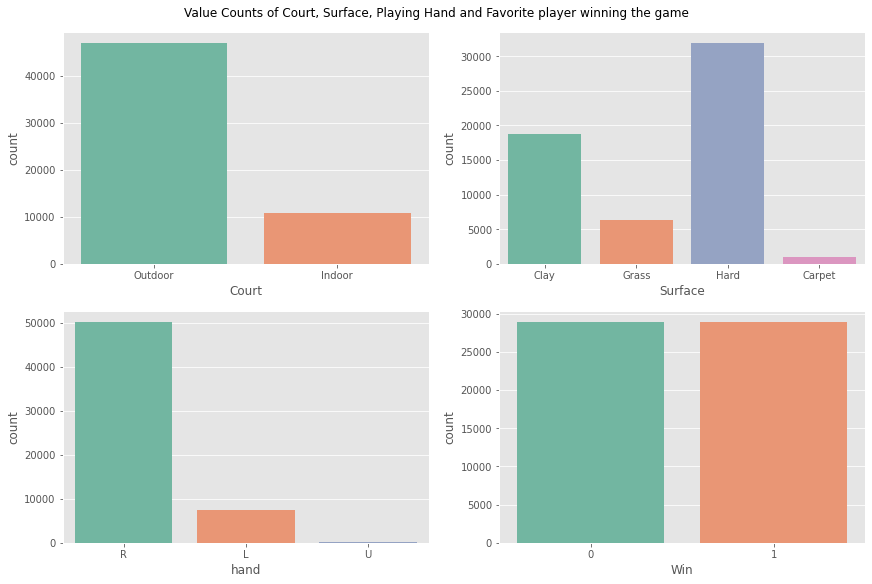

In [16]:
categorical = ["Court", "Surface", "hand", "win", "Round"]
numerical = [ 
    'Rank','Pts', 'sets', 'B365','ht', 'age', 'ace', 'df', 'svpt', 
    '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', "1stServeEffectiveness", 
    "Ret2ServPtsRatio", "PtsDominanceRatio", "BPRatio", "Pts2Sets_OP_Ratio", "Pts2Gms_OP_Ratio", 
    "Gms2Sets_OP_Ratio", "BP_OP_Ratio", "BPSaved_OP_Ratio", "BPConverted_OP_Ratio", "Ace%", 
    "DF%", "1stServe%", "1stReturnWon%"
]
other = ["year", "month", "name"]

# Useful lists
res = ["Win"]

fig, axs = plt.subplots(2,2, constrained_layout=True)
fig.suptitle("Value Counts of Court, Surface, Playing Hand and Favorite player winning the game")
sns.countplot(x="Court", data=df, palette="Set2", ax = axs[0,0])
sns.countplot(x="Surface", data=df, palette="Set2", ax = axs[0,1])
sns.countplot(x="hand", data=df, palette="Set2", ax = axs[1,0])
sns.countplot(x="Win", data=df, palette="Set2", ax = axs[1,1])

plt.show()

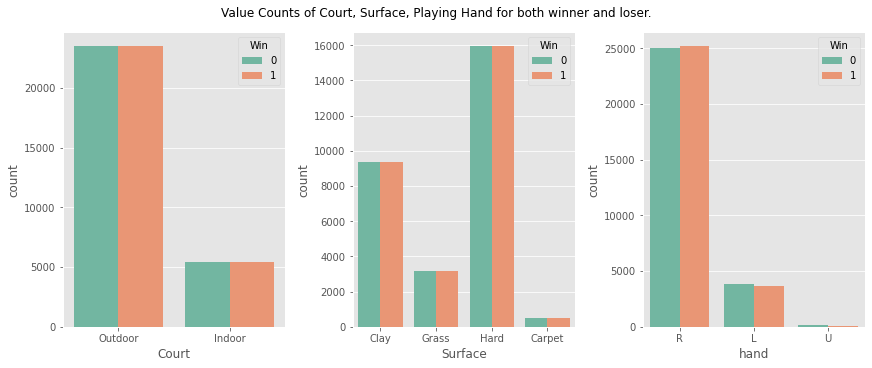

In [17]:
plt.rcParams["figure.figsize"] = [12,5]
fig, axs = plt.subplots(1, 3, constrained_layout=True)
fig.suptitle("Value Counts of Court, Surface, Playing Hand for both winner and loser.")
sns.countplot(x="Court", data=df, hue = "Win", palette="Set2", ax = axs[0])
sns.countplot(x="Surface", data=df, hue = "Win", palette="Set2", ax = axs[1])
sns.countplot(x="hand", data=df, hue = "Win", palette="Set2", ax = axs[2])

plt.show()

Obvious observations:
1. Most of the tournaments are played **outdoors** and the favorite has higher chances of winning when it's that way.
2. Hard is the most common surface, followed by clay, grass and carpet (in order). 
3. Most of the players are right-handed, just like in real workd.

Nothing surprising here, we're just getting to know the data better!

### 6.3. Numerical data

Time for a heatmap? Let's see if there's correlation between numeric variables and the target feature by taking a look at the correlation matrix.

In [18]:
# Pearson Correlation
corr_matrix = df[numerical + res].corr().sort_values(by=["Win"])
corr_matrix

,Rank,Pts,sets,B365,ht,age,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,1stServeEffectiveness,Ret2ServPtsRatio,PtsDominanceRatio,BPRatio,Pts2Sets_OP_Ratio,Pts2Gms_OP_Ratio,Gms2Sets_OP_Ratio,BP_OP_Ratio,BPSaved_OP_Ratio,BPConverted_OP_Ratio,Ace%,DF%,1stServe%,1stReturnWon%,Win
B365,0.247201,-0.195766,-0.224321,1.000000,-0.051961,-0.011301,-0.082458,0.051292,0.043898,0.008823,-0.071371,-0.009932,-0.018509,0.133483,0.181259,0.015809,-0.118248,0.225326,-0.100548,-0.227240,-0.226232,-0.225123,0.024092,-0.016665,-0.188567,-0.097165,0.051702,-0.038443,-0.109483,-0.314683
PtsDominanceRatio,0.483353,-0.632759,-0.891533,0.225326,-0.103779,0.027444,-0.199547,0.256089,0.209206,0.050140,-0.214123,-0.014422,-0.024082,0.483208,0.653686,0.169223,-0.598007,1.000000,-0.393198,-0.908927,-0.919127,-0.896395,0.153878,-0.075966,-0.746352,-0.262817,0.253146,-0.171792,-0.596796,-0.216775
bpFaced,0.361306,-0.469505,-0.577885,0.181259,-0.301689,-0.003969,-0.478530,0.260892,0.363324,0.200252,-0.200102,0.034395,0.058929,0.909615,1.000000,-0.037676,-0.455548,0.653686,-0.037552,-0.638376,-0.655288,-0.628177,0.328581,0.174058,-0.581927,-0.560115,0.210698,-0.112528,-0.073649,-0.164900
Rank,1.000000,-0.371407,-0.485064,0.247201,-0.041252,-0.089613,-0.112673,0.157272,0.133743,0.045069,-0.099031,0.007845,0.017842,0.268122,0.361306,0.072705,-0.275773,0.483353,-0.226666,-0.495648,-0.478872,-0.488446,0.060303,-0.039476,-0.386149,-0.145412,0.150137,-0.085716,-0.299779,-0.162298
bpSaved,0.268122,-0.365319,-0.380676,0.133483,-0.179259,-0.006043,-0.305998,0.253960,0.460519,0.293325,-0.005431,0.133748,0.160464,1.000000,0.909615,-0.023951,-0.490161,0.483208,0.163064,-0.442533,-0.446791,-0.430144,0.523520,0.469787,-0.449299,-0.391252,0.172350,-0.082104,-0.095907,-0.125228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gms2Sets_OP_Ratio,-0.488446,0.615274,0.960808,-0.225123,0.148653,-0.035784,0.259526,-0.211851,-0.109213,0.014254,0.283272,0.079116,0.092873,-0.430144,-0.628177,-0.142273,0.422381,-0.896395,0.438385,0.995168,0.912031,1.000000,-0.041711,0.138446,0.731786,0.305964,-0.226213,0.153448,0.482194,0.207011
sets,-0.485064,0.641880,1.000000,-0.224321,0.133410,-0.027863,0.273656,-0.176115,0.018984,0.114535,0.373326,0.144517,0.233890,-0.380676,-0.577885,-0.140614,0.427332,-0.891533,0.441090,0.958712,0.902899,0.960808,-0.055869,0.135707,0.717095,0.297737,-0.214891,0.156417,0.489747,0.210543
Pts2Gms_OP_Ratio,-0.478872,0.622686,0.902899,-0.226232,0.127436,-0.036648,0.211783,-0.234554,-0.159057,-0.012880,0.248068,0.042680,0.038428,-0.446791,-0.655288,-0.168619,0.413524,-0.919127,0.462223,0.932540,1.000000,0.912031,-0.032216,0.152830,0.745852,0.263393,-0.244385,0.173906,0.531368,0.210545
Pts2Sets_OP_Ratio,-0.495648,0.635893,0.958712,-0.227240,0.124678,-0.039090,0.219110,-0.233929,-0.167630,-0.027145,0.234234,0.044606,0.030842,-0.442533,-0.638376,-0.160186,0.433483,-0.908927,0.449369,1.000000,0.932540,0.995168,-0.042526,0.147834,0.742265,0.272438,-0.236061,0.158355,0.523462,0.211182


Creating a heatmap for all the variables we have would create an ugly plot with a lot of numbers overlapping each other. That's not nice to see... I'll be instead showing the most-correlated with player 1 actually winning the game.

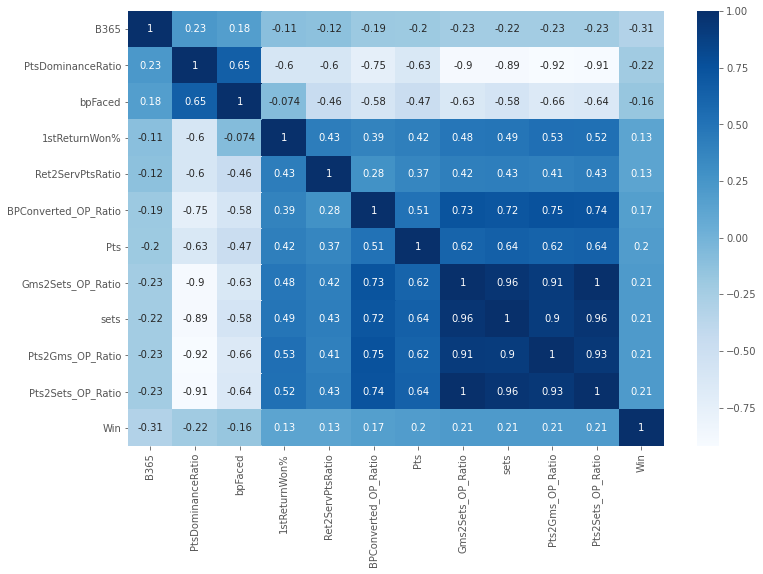

In [19]:
plt.rcParams["figure.figsize"] = [12,8]
matrix = pd.concat([corr_matrix.iloc[:3], corr_matrix.iloc[-9:]])

sns.heatmap(matrix[matrix.index], cmap='Blues', annot=True)
plt.show()

This is interesting. None of the correlations is huge, but some are above the 20% threshold, which makes them worth looking at! 

We can get good insights from here, like the fact that the **Points to Games Over-Performance Ratio**, the **Points to Sets Over-Performance Ratio**, the **Games to Sets Over-Performance Ratio** and the average number of sets won are somewhat correlated as well as the **Points Dominance Ratio** and, obviously, the **odds**. We can tell bookies are doing a good job if they are the number-one feature in terms of correlation. 

What's surprising, at least it shocks me, is that the Win% doesn't seem much relevant, nor any other advanced feature which is not a ratio. Curious.

Most of those stats being highly correlated between themselves. And it makes sense, they share a linear relationship. Should we study that?

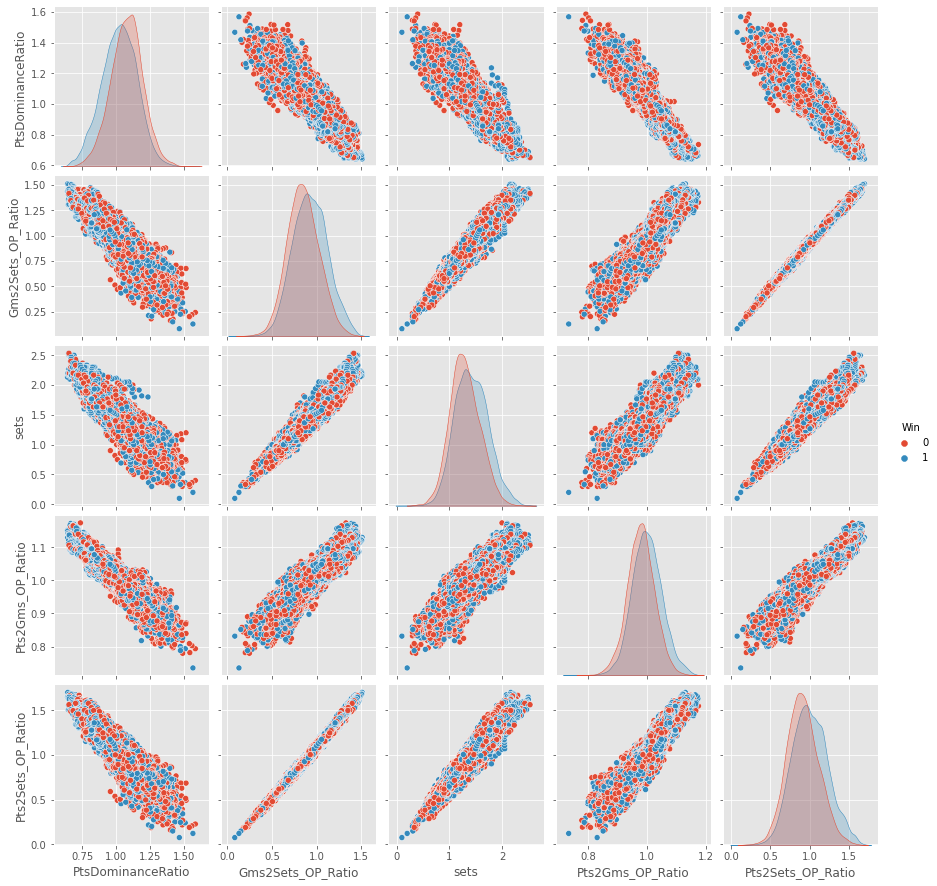

In [20]:
sns.pairplot(data = df[["Win", "PtsDominanceRatio", "Gms2Sets_OP_Ratio", "sets", "Pts2Gms_OP_Ratio", "Pts2Sets_OP_Ratio"]], diag_kind = 'kde', hue = "Win")
plt.show()

Well that's very clear right? They all show a pretty strong linear relationship and it's a signal of dependence. That's normal, as they were built as a combination of other basic features.

I've also added this hue which indicates if a certain point resulted in a win or loss by that player, just to see how colors were distributed throughout the graphs. To be honest, I expected it to be more distinguishible. If we look at the numbers as well as the plots, the pattern exists: in a general way, orange points tend to occupy more space in one extreme and blue in the other. But, again, it's not extremely clear.

I'd now move to feature importance but I'd first like to start encoding categorical data, so I can take them into account too.

### 6.4. Feature Importance

In [21]:
#One hot encoding
surface=pd.get_dummies(df["Surface"], prefix='surface_')
df = pd.concat([df,surface],axis=1)
df.drop(columns='Surface', inplace=True)

hand=pd.get_dummies(df["hand"], prefix='hand_')
df = pd.concat([df,hand],axis=1)
df.drop(columns='hand', inplace=True)

playing_round=pd.get_dummies(df["Round"])
df = pd.concat([df,playing_round],axis=1)
df.drop(columns='Round', inplace=True)

df["Court"].replace(to_replace=['Outdoor','Indoor'],value=[1,0], inplace=True)

Now that we have all relevant data in numeric format, it's time to decide upon the features we'll be using for the model. There's several ways to do so, but I'm going to use one of the easiest and simplest because that can probably be enough. 

I'll be using sklearn's RandomForestClassifier, which could serve as the predictive model in and of itself, but it also internally ranks features in terms of importance. That's why I'm choosing this method. Again, there are way more ways to do it and are probably way better.

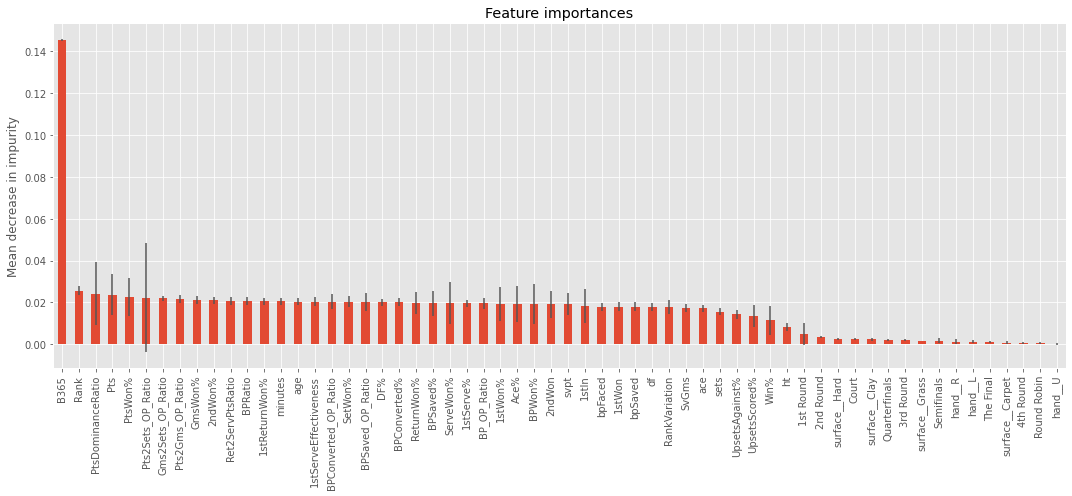

In [22]:
df.dropna(subset=["minutes", "ht"], inplace=True)
df.fillna(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

feature_names = [feature for feature in df.drop(columns=["Win", "name", "year", "month"]).columns]
forest = RandomForestClassifier(random_state=0)
forest.fit(df.drop(columns=["Win", "name", "year", "month"]), df[["Win"]])

importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.rcParams["figure.figsize"] = [15,7]
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

This plot is ordered in terms of importance. We see the odds being the most important by far, and then the vast majority have pretty much the same relevance. I'm glad 7 of the top 10 are the advanced, created features.

Lower imporance features are those that correspond to the one-hot encoded features. That makes sense and this shouldn't be a reason to leave them out. Even so, I'm planning on dropping the columns corresponding to the round being played, I don't like this feature.

I'll also drop height.

Apart from that, I think we actually have enough! The data observed in our correlation visualization and what this random forest model provides is insightful and helps us determine what stats are important.

## 7. CONCLUSIONS

This project has given us some useful insights in terms of which stats and features may be the most important when it comes to forecasting a match-winner in tennis. Most of the tasks were focused on the data preparation and processing, but we also used some visualizations to understand better our data and get the results we were looking for.

Odds are, by far, the most important feature. And it makes sense, bookies are right around 70% of the time! It also surprised me the relevance the player's rank and points have. I conclude from this that ATP points are solid and significant, pretty well computed.

Apart from that, we've already seen some more advanced ratios and how they correlate with the player's chances of winning, as well as some other more advanced stats. 

Age seems to be a considerable factor, more than a lot more features which someone could have thought were important (like Ace%, Double Faults...).

Lastly, I want to highlight my surprise to see that the Win% within the last 30 games seems negligible. Also, upset-related stats aren't much important either.


## 8. IMPROVEMENTS & NEXT STEPS
There's several things I could have done. I wanted to keep this as simple as possible, even though it ended up being quite long. 

What I've restricted myself from doing is adding a lot more new features, like the **implied probability** (which comes from the odds), **player fatigue**...

I could have also studied the number of previous games we'd be performing the rolling averages over. I chose 30 but it could have been any other number. For better results, we should aim to find the number that optimizes our future results.

The next steps are clear: build the model and find a betting strategy to make it profitable.

## 9. REFERENCES
The data comes from two sources:
* [Jeff Sackmann](https://github.com/JeffSackmann/tennis_atp): he has an amazing set of files with almost everything one would need. I used some of his files to get the stats per match.
* [Tennis-data.co.uk](http://www.tennis-data.co.uk/alldata.php): It was used to get the information related to odds as well as the match results and other qualitative information.

I also used [Ultimate Tennis Statistics](https://www.ultimatetennisstatistics.com/glossary) to create new features and learn more about tennis itself.
